In [32]:
# !pip install torchviz

In [ ]:
# задача обучить модель распознавать картинки одежды 
# для этого ниже загружается датасет fashionmnist

In [33]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm
from torchviz import make_dot
import matplotlib.pyplot as plt

In [34]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download=True, transform=transform)

In [35]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
train_item = next(iter(train_loader))
test_item = next(iter(test_loader))
len(train_item), len(test_item), train_item[0].shape, train_item[1].shape

(2, 2, torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [ ]:
# содается класс модели, слои, модель представляет собой полносвязную сеть
# с добавлением dropout, normalization, которые нужны для предотвращения переобучения и
# dropuot рандомно удаляет часть связей в слое, чтобы нейроны не изучали так называемый шум, не подстраивалсь друг под друга 
# batch normalization нормализует вход в слое, преобразует данные в диапазон со средним значение 0, отклонением 1, которые потом изменяются

In [37]:
class NNModel(nn.Module):
    def __init__(self,
                 layers_size = [784, 32, 16, 10], # <<------------------ 49 > 784  (1)
                 dropout_prob = 1.0
                 ):
        super().__init__()
        # self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 4)
        self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 1)
        #
        
        layers = [nn.Linear(layers_size[i], layers_size[i+1]) for i in range(len(layers_size)-1)]
        norms = [nn.BatchNorm1d(inp_size, affine  = False) for inp_size in layers_size[1:-1]]
        
        self.layers = nn.ModuleList(layers) # <<--------------- (2)
        self.norm = nn.ModuleList(norms) # <<--------------- (2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, batch):
        bs = batch.shape[0]
        batch = self.conv(batch).reshape(bs, -1)

        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                batch = self.dropout(self.relu(self.norm[i](layer(batch))))
            else:
                batch = layer(batch)
        return batch

    def print_net(self):
        print(self.conv)
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                print(layer)
                print(self.norm[i])
                print(self.relu)
                print(self.dropout)
            else:
                print(layer)

        return

In [38]:
# 1. изменил размер входных данных с 49 на 784 т.к. после использования свертки с шагом 1 получаем размер 28*28 
# 2. добавил modulelist т.к. torch сохраняет параметры модели в граф, если добавить слои в list они неправильно дабавятся в граф, это проводит у ошибке ниже
# при добавлении параметров модели в оптимизатор их просто нет 

In [39]:
mlp  = NNModel(dropout_prob = 0.1)

# predictions = mlp(train_item[0])
# make_dot(predictions, params=dict(mlp.named_parameters()))
mlp.print_net()

Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
Linear(in_features=784, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=16, out_features=10, bias=True)


In [ ]:
# обучение модели 
# по выходу сети и целевому значению считается ошибка 
# распростроняется по сети, затем изменяются параметры
# модель тестируется

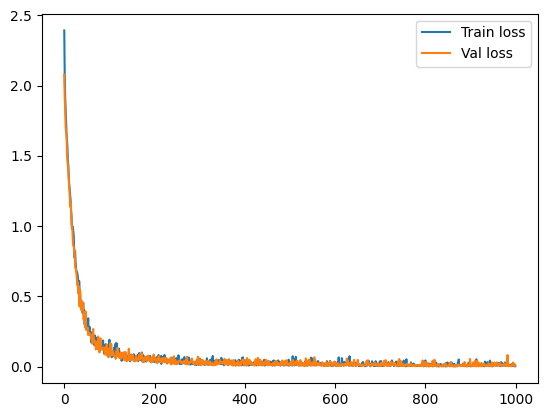

In [40]:
num_epochs = 1000
DEBUG = False
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr =  0.01)

logger = {'train':[],
          'eval' :[]
          }
for epoch in range(num_epochs):

    epoch_stat = []

    # train part

    mlp.train()
    for batch in [train_item]: # для одного батча
        optimizer.zero_grad() # <<--------------- (3)
        
        images, labels = batch
        images, labels = images.float(), labels.long()
        predictions = mlp(images)
        loss = ce_loss(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_stat.append(loss.item())

    if DEBUG: print(f"train loss value = {np.mean(epoch_stat)}")
    logger['train'].append(np.mean(epoch_stat))


    # eval part
    with torch.no_grad():

        eval_stat = []
        for batch in [train_item]:

            images, labels = batch
            images, labels = images.float(), labels.long()

            predictions = mlp(images)
            loss = ce_loss(predictions, labels)
            # loss.backward() # <<--------------- (4)
            # optimizer.step() # <<--------------- (4)

            eval_stat.append(loss.item())
    if DEBUG: print(f"eval loss value = {np.mean(eval_stat)}")
    logger['eval'].append(np.mean(eval_stat))

plt.plot(logger['train'], label='Train loss' )
plt.plot(logger['eval'], label='Val loss')
plt.legend()
plt.show()

In [41]:
# 3. нужно очищать градиенты в оптимизаторе при последующем их вычислении иначе они просто останутся там и наложатся на новые
# 4. здесь мы тестируем модель, строчка "with torch.no_grad():" отключает вычисление градиентов, мы не можем оптимизировать параметры

In [42]:
mlp

NNModel(
  (conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (norm): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [43]:
# pytorch_total_params = sum(p.numel() for p in mlp.parameters())
# pytorch_total_params